# Premiers pas avec LangGraph

Objectif de ce notebook :  
- Comprendre ce qu’est un **StateGraph**.  
- Construire un **toy graph** (sans LLM) pour bien voir la mécanique.  
- Puis un **mini agent conversationnel** avec un seul noeud LLM.  
- Visualiser le graphe directement dans le notebook.


## Idée clé : un workflow comme un graphe

Dans LangGraph :

- **State** : l’état partagé qui circule (données, messages, résultats intermédiaires).  
- **Nodes** : des fonctions qui lisent l’état et renvoient un **update** de l’état.  
- **Edges** : les transitions entre noeuds (linéaires ou conditionnelles).  
- **StateGraph** : l’objet qui assemble tout ça et que l’on compile en `graph` exécutable.

Schéma conceptuel :

```text
          +---------+       +---------+       +---------+
  START ->|  Node A | ----> |  Node B | ----> |  Node C |--> END
          +---------+       +---------+       +---------+
               
```

## 🔧 Installation (à faire une fois)

Décommentez si besoin.

In [1]:
!pip install -U langgraph langchain-ollama python-dotenv
# Pour LM Studio (API compatible OpenAI):
!pip install -U langgraph langchain-openai python-dotenv
# Pour certaines visualisations (Mermaid PNG) :
# !pip install -U grandalf

## 1️⃣ Un premier graphe *sans LLM*

On part d’un exemple très simple :  
- l’état est juste un entier `value`,  
- on applique deux noeuds : `add_one` puis `double`,  
- on voit comment le **StateGraph** fonctionne.

```text
value initial -> [add_one] -> [double] -> value final
```

In [2]:
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class SimpleState(TypedDict):
    value: int

def add_one(state: SimpleState) -> SimpleState:
    print(f"[add_one] state in  = {state}")
    return {"value": state["value"] + 1}

def double(state: SimpleState) -> SimpleState:
    print(f"[double] state in  = {state}")
    return {"value": state["value"] * 2}

builder = StateGraph(SimpleState)
builder.add_node("add_one", add_one)
builder.add_node("double", double)

builder.add_edge(START, "add_one")
builder.add_edge("add_one", "double")
builder.add_edge("double", END)

simple_graph = builder.compile()



- Chaque noeud prend un `state` et renvoie un **fragment** de state.  
- LangGraph s’occupe de **fusionner** les updates et de faire circuler l’état de noeud en noeud.

## 2️⃣ Visualiser le graphe

LangGraph propose une méthode `get_graph()` qui permet de générer :  
- un **ASCII** du graphe,  
- du **Mermaid** (texte),  
- éventuellement un PNG/SVG selon les libs installées.

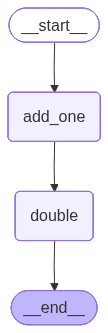

In [3]:
g = simple_graph.get_graph()

# print("\nMermaid code:")
# print(g.draw_mermaid())

# print("ASCII graph:")
# print(g.draw_ascii())

# Si grandalf est installé, on peut aussi générer un PNG directement :
from IPython.display import Image
Image(g.draw_mermaid_png())

In [4]:
result = simple_graph.invoke({"value": 2})
print(f"[END] final state = {result}")

[add_one] state in  = {'value': 2}
[double] state in  = {'value': 3}
[END] final state = {'value': 6}


## 3️⃣ Mini agent conversationnel

On passe maintenant à un **state basé sur des messages**, plus proche d’un vrai agent IA.

On va :  
- utiliser `MessagesState` (state pré-défini dans LangGraph),  
- créer un seul noeud `assistant` qui appelle un LLM via LangChain,  
- connecter `START -> assistant -> END`.

C’est la version la plus minimale d’un agent LangGraph.

In [5]:
import os
from dotenv import load_dotenv

from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage

# Charger les variables d'environnement depuis le fichier .env
load_dotenv()

# 1. Définir le state
class ChatState(MessagesState):
    """State avec une clé 'messages' (liste de messages)."""
    pass

# 2. Initialiser le modèle local
llm_type = os.getenv("LOCAL_LLM_TYPE", "ollama")

if llm_type == "ollama":
    from langchain_ollama import ChatOllama
    
    ollama_base_url = os.getenv("OLLAMA_BASE_URL", "http://localhost:11434")
    ollama_model = os.getenv("OLLAMA_MODEL", "llama3.2:latest")
    
    chat_model = ChatOllama(
        model=ollama_model,
        base_url=ollama_base_url,
        temperature=0.2,
    )
    print(f"Utilisation d'Ollama avec le modèle {ollama_model}")
    
elif llm_type == "lmstudio":
    from langchain_openai import ChatOpenAI
    
    lmstudio_base_url = os.getenv("LMSTUDIO_BASE_URL", "http://localhost:1234/v1")
    lmstudio_model = os.getenv("LMSTUDIO_MODEL", "local-model")
    
    chat_model = ChatOpenAI(
        model=lmstudio_model,
        base_url=lmstudio_base_url,
        api_key="not-needed",  # LM Studio ne nécessite pas de clé API
        temperature=0.2,
    )
    print(f"Utilisation de LM Studio avec le modèle {lmstudio_model}")
    
else:
    raise ValueError(f"LOCAL_LLM_TYPE non reconnu: {llm_type}. Utilisez 'ollama' ou 'lmstudio'.")

# 3. Définir le noeud principal
def assistant_node(state: ChatState) -> ChatState:
    """
    Lit les messages dans le state, appelle le LLM,
    renvoie un update avec le nouveau message AI.
    """

    #Ici on appelle le LLM sans ajouter de prompt maison, on pourrait le faire.
    response = chat_model.invoke(state["messages"])
    return {"messages": [response]}

# 4. Construire le graphe
builder = StateGraph(ChatState)
builder.add_node("assistant", assistant_node)
builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)

chat_graph = builder.compile()
g = chat_graph.get_graph()
#Image(g.draw_mermaid_png())

Utilisation de LM Studio avec le modèle mistralai/devstral-small-2-2512


In [6]:
# 5. Lancer une requête
initial_state: ChatState = {
    "messages": [HumanMessage(content="Explique en 3 phrases ce qu'est LangGraph et en quoi il complète LangChain.")]
}

result_state = chat_graph.invoke(initial_state)
for m in result_state["messages"]:
    print(f"{m.type.upper()}: {m.content}\n")

HUMAN: Explique en 3 phrases ce qu'est LangGraph et en quoi il complète LangChain.

AI: LangGraph est un framework open-source conçu pour construire des agents conversationnels avancés en utilisant une approche basée sur les graphes d'état. Il se distingue par sa capacité à modéliser des flux de travail complexes avec des transitions conditionnelles entre différentes étapes, ce qui permet une gestion fine des interactions et des décisions dans les systèmes basés sur le langage.

LangGraph complète LangChain en offrant une alternative plus structurée et flexible pour la création d'agents, notamment lorsque les workflows nécessitent des logiques décisionnelles dynamiques ou des interactions multi-étapes. Alors que LangChain propose des outils génériques pour intégrer des modèles de langage avec d'autres API, LangGraph se concentre sur l'orchestration des processus à travers des graphes d'état, facilitant ainsi la construction d'agents plus robustes et adaptatifs.

Ensemble, LangChain et 

## CCL : Rôle de ce notebook 

- Le notebook LangChain montre comment **construire un agent individuel / une chaîne**.  
- Ce notebook LangGraph montre comment **orchestrer** des étapes en graphe.  
- Le dernier notebook (météo + calendrier) illustrera ensuite un **pattern d’agent plus riche** avec plusieurs tools et une logique réelle.

